In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
dataset = torchvision.datasets.VOCDetection("../../data", year='2007', image_set='train', download=False, transform=None, target_transform=None, transforms=None)

{'name': 'boat', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '274', 'ymin': '11', 'xmax': '437', 'ymax': '279'}}
{'name': 'boat', 'pose': 'Frontal', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '184', 'ymin': '214', 'xmax': '281', 'ymax': '252'}}


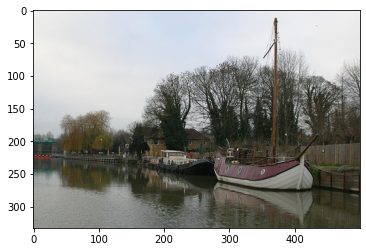

In [3]:
data = dataset[13]
img = data[0]
target = data[1]
plt.imshow(img)
for elem in target['annotation']['object']:
    print(elem)

In [8]:
class VOCDet(Dataset):
    labelNames = {
                    "boat": torch.tensor(0, dtype=torch.long), 
                    "car": torch.tensor(1, dtype=torch.long), 
                    "aeroplane": torch.tensor(2, dtype=torch.long),
                    "bicycle": torch.tensor(3, dtype=torch.long), 
                    "bird": torch.tensor(4, dtype=torch.long),
                    "bus": torch.tensor(5, dtype=torch.long),
                    "bottle": torch.tensor(6, dtype=torch.long),
                    "cat": torch.tensor(7, dtype=torch.long),
                    "chair": torch.tensor(8, dtype=torch.long),
                    "cow": torch.tensor(9, dtype=torch.long), 
                    "diningtable": torch.tensor(10, dtype=torch.long), 
                    "dog": torch.tensor(11, dtype=torch.long), 
                    "motorbike": torch.tensor(12, dtype=torch.long), 
                    "person": torch.tensor(13, dtype=torch.long), 
                    "pottedplant": torch.tensor(14, dtype=torch.long), 
                    "sofa": torch.tensor(15, dtype=torch.long), 
                    "sheep": torch.tensor(16, dtype=torch.long), 
                    "train": torch.tensor(17, dtype=torch.long), 
                    "horse": torch.tensor(18, dtype=torch.long), 
                    'tvmonitor': torch.tensor(19, dtype=torch.long), 
                 }
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Resize([320, 320])])
    
    def __init__(self, transform=None):
        self.data_fetcher = torchvision.datasets.VOCDetection("../../data", year='2007', image_set='train', download=False, transform=None, target_transform=None, transforms=None)
        self.transform = transform if transform is not None else self.preprocess
        
        self.S = 7
        self.B = 2
        self.C = 20
        
    def __getitem__(self, idx):
        data = self.data_fetcher[idx]
        original_img = data[0]
        if self.transform is not None:
            img = self.transform(original_img)
        
        annotations = data[1]['annotation']['object']
        labels = []
        bboxes = []
        for annotation in annotations:
            l_name = annotation['name']
            l = self.labelNames[l_name]
            labels.append(l)
            b_dict = annotation['bndbox']
            b = [ float(b_dict['xmin']), 
                  float(b_dict['ymin']), 
                  float(b_dict['xmax']), 
                  float(b_dict['ymax']) ]
            bboxes.append(b)
            
        bboxes = torch.tensor(bboxes)
        labels = torch.tensor(labels)
        
        
        h, w = TF.to_tensor(original_img).shape[-2:]
        bboxes /= torch.tensor([[w, h, w, h]]).expand_as(bboxes) # normalize (x1, y1, x2, y2) w.r.t. image width/height.
        
        targets = self.encode(bboxes, labels)
        
        return img, targets
    
    def __len__(self):
        return len(self.data_fetcher)
        

    def encode(self, boxes, labels):
        """ Encode box coordinates and class labels as one target tensor.
        Args:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...], normalized from 0.0 to 1.0 w.r.t. image width/height.
            labels: (tensor) [c_obj1, c_obj2, ...]
        Returns:
            An encoded tensor sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        """

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C

        target = torch.zeros(S, S, N)
        cell_size = 1.0 / float(S)
        boxes_wh = boxes[:, 2:] - boxes[:, :2] # width and height for each box, [n, 2]
        boxes_xy = (boxes[:, 2:] + boxes[:, :2]) / 2.0 # center x & y for each box, [n, 2]
        for b in range(boxes.size(0)):
            xy, wh, label = boxes_xy[b], boxes_wh[b], int(labels[b])

            ij = (xy / cell_size).ceil() - 1.0
            i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
            x0y0 = ij * cell_size # x & y of the cell left-top corner.
            xy_normalized = (xy - x0y0) / cell_size # x & y of the box on the cell, normalized from 0.0 to 1.0.

            # TBM, remove redundant dimensions from target tensor.
            # To remove these, loss implementation also has to be modified.
            for k in range(B):
                s = 5 * k
                target[j, i, s  :s+2] = xy_normalized
                target[j, i, s+2:s+4] = wh
                target[j, i, s+4    ] = 1.0
            target[j, i, 5*B + label] = 1.0

        return target
    
    
    def decode(self, pred_tensor):
        """ Decode tensor into box coordinates, class labels, and probs_detected.
        Args:
            pred_tensor: (tensor) tensor to decode sized [S, S, 5 x B + C], 5=(x, y, w, h, conf)
        Returns:
            boxes: (tensor) [[x1, y1, x2, y2]_obj1, ...]. Normalized from 0.0 to 1.0 w.r.t. image width/height, sized [n_boxes, 4].
            labels: (tensor) class labels for each detected boxe, sized [n_boxes,].
            confidences: (tensor) objectness confidences for each detected box, sized [n_boxes,].
            class_scores: (tensor) scores for most likely class for each detected box, sized [n_boxes,].
        """
        S, B, C = self.S, self.B, self.C
        boxes, labels, confidences, class_scores = [], [], [], []

        cell_size = 1.0 / float(S)

        conf = pred_tensor[:, :, 4].unsqueeze(2) # [S, S, 1]
        for b in range(1, B):
            conf = torch.cat((conf, pred_tensor[:, :, 5*b + 4].unsqueeze(2)), 2)
        conf_mask = conf > self.conf_thresh # [S, S, B]

        # TBM, further optimization may be possible by replacing the following for-loops with tensor operations.
        for i in range(S): # for x-dimension.
            for j in range(S): # for y-dimension.
                class_score, class_label = torch.max(pred_tensor[j, i, 5*B:], 0)

                for b in range(B):
                    conf = pred_tensor[j, i, 5*b + 4]
                    prob = conf * class_score
                    if float(prob) < self.prob_thresh:
                        continue

                    # Compute box corner (x1, y1, x2, y2) from tensor.
                    box = pred_tensor[j, i, 5*b : 5*b + 4]
                    x0y0_normalized = torch.FloatTensor([i, j]) * cell_size # cell left-top corner. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    xy_normalized = box[:2] * cell_size + x0y0_normalized   # box center. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    wh_normalized = box[2:] # Box width and height. Normalized from 0.0 to 1.0 w.r.t. image width/height.
                    box_xyxy = torch.FloatTensor(4) # [4,]
                    box_xyxy[:2] = xy_normalized - 0.5 * wh_normalized # left-top corner (x1, y1).
                    box_xyxy[2:] = xy_normalized + 0.5 * wh_normalized # right-bottom corner (x2, y2).

                    # Append result to the lists.
                    boxes.append(box_xyxy)
                    labels.append(class_label)
                    confidences.append(conf)
                    class_scores.append(class_score)

        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0) # [n_boxes, 4]
            labels = torch.stack(labels, 0)             # [n_boxes, ]
            confidences = torch.stack(confidences, 0)   # [n_boxes, ]
            class_scores = torch.stack(class_scores, 0) # [n_boxes, ]
        else:
            # If no box found, return empty tensors.
            boxes = torch.FloatTensor(0, 4)
            labels = torch.LongTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)

        return boxes, labels, confidences, class_scores    
    
    
    def example(self, idx):
        data = self.__getitem__(idx)
        img, targets = data
        targets


In [10]:
dataset = VOCDet()
d = dataset[1][1]
d = dataset.decode(d)
print(d)

AttributeError: 

In [ ]:
# dataset = VOCDet()
# d = dataset[1]
# dataloader = DataLoader(dataset, batch_size=1)
# for i, data in enumerate(dataloader):
#     if i != 1:
#         continue
    
#     img, targets = data
#     targets = targets[0]
#     print(img.shape)
#     print(targets.shape)
#     for i in range(7):
#         for j in range(7):
#             for box_i in range(2):
# #                 print(targets[i,j,box_i*5:box_i*5+5])
#                 bbox = targets[i,j,box_i*5:box_i*5+5][:4]
#                 h, w = 320, 320
#                 bbox *= torch.tensor([w, h, w, h]) # normalize (x1, y1, x2, y2) w.r.t. image width/height.
#                 bbox = bbox.to(torch.long)
# #                 print(i, j)
# #                 print(bbox)
                
#                 if not (bbox == torch.zeros(4)).all():
#                     img_draw = np.array(TF.to_pil_image(img.squeeze()))
#                     tl = (bbox[0].item(), bbox[1].item())
#                     rb = (bbox[2].item(), bbox[3].item())
#                     print(targets[i,j,2*5:], "all")
# #                     tl = (10, 10)
# #                     rb = (100, 100)                   
#                     print(tl, rb)
#                     img_draw = cv2.rectangle(img_draw, tl, rb, (255,0,0), 2)
#                     plt.figure()
#                     plt.imshow(img_draw)

#     if i > 10:
#         break